**Approach 1**

In [89]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# Load the dataset
df = pd.read_csv('/content/bank-additional-full[1].csv', sep=';')

# Create a copy of the DataFrame for manipulation
data = df.copy()

# Define categorical and numeric columns
categorical_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan',
                     'contact', 'month', 'day_of_week', 'poutcome']
numeric_columns = ['age', 'campaign', 'pdays', 'previous',
                 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
                 'euribor3m', 'nr.employed']

# Fill missing values for categorical columns with mode
for col in categorical_columns:
  data[col].fillna(data[col].mode()[0], inplace=True)

# Fill missing values for numeric columns with median
for col in numeric_columns:
  data[col].fillna(data[col].median(), inplace=True)

# Convert target variable to binary (0 and 1)
data['y'] = data['y'].map({'yes': 1, 'no': 0})

# Drop 'duration' to prevent leakage in modeling
data.drop(columns=['duration'], inplace=True)

# Prepare the feature matrix and target vector
X = data.drop(columns=['y'])  # Features
y = data['y']  # Target variable

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Set up the ColumnTransformer for categorical and numerical features
preprocessor = ColumnTransformer(
  transformers=[
      ('num', 'passthrough', numeric_columns),  # Keep numeric columns as is
      ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_columns)  # One-hot encode categorical columns
  ]
)

# Transform the training data
X_train_encoded = preprocessor.fit_transform(X_train)
X_test_encoded = preprocessor.transform(X_test)

# Resampling using SMOTE for handling class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_encoded, y_train)

# Define the XGBoost model with class weights
scale_pos_weight = len(y_train_resampled[y_train_resampled == 0]) / len(y_train_resampled[y_train_resampled == 1])
xgb_model = XGBClassifier(
  scale_pos_weight=scale_pos_weight,
  use_label_encoder=False,
  eval_metric='logloss',
  random_state=42
)

# Set up the parameter grid for hyperparameter tuning
param_dist = {
  'n_estimators': np.arange(50, 200, 50),
  'max_depth': np.arange(3, 10, 2),
  'learning_rate': np.linspace(0.01, 0.2, 5),
  'subsample': [0.8, 1.0],
  'colsample_bytree': [0.8, 1.0]
}

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, n_iter=10, cv=3, scoring='f1', n_jobs=-1, verbose=2)

# Fit the model
random_search.fit(X_train_resampled, y_train_resampled)

# Best parameters
print("Best parameters found: ", random_search.best_params_)

# Make predictions
y_pred = random_search.predict(X_test_encoded)

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [14:39:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters found:  {'subsample': 1.0, 'n_estimators': 50, 'max_depth': 9, 'learning_rate': 0.0575, 'colsample_bytree': 1.0}
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      7310
           1       0.54      0.43      0.48       928

    accuracy                           0.89      8238
   macro avg       0.74      0.69      0.71      8238
weighted avg       0.89      0.89      0.89      8238



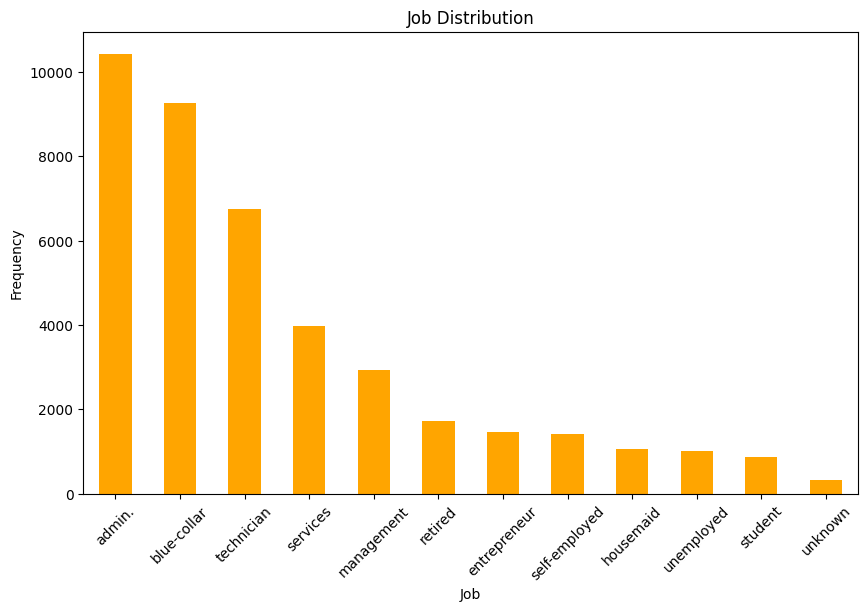

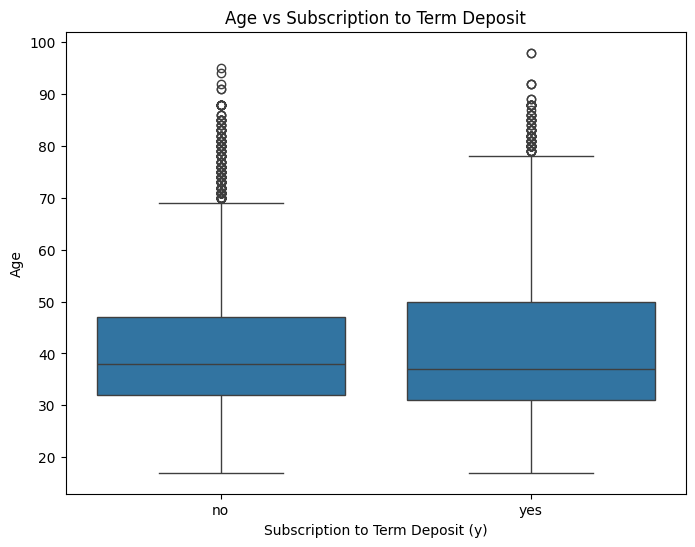

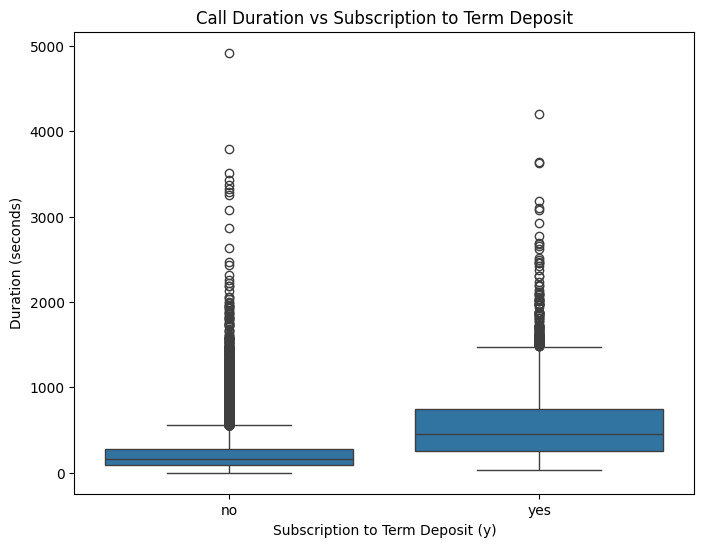

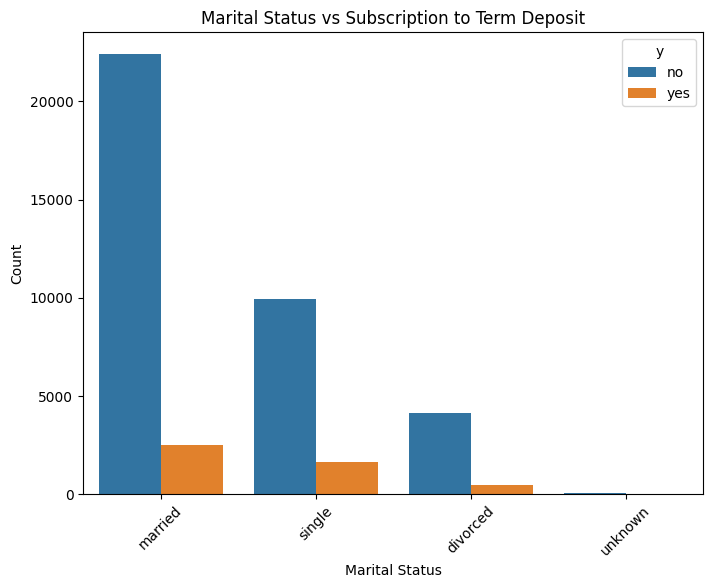

Correlation of features with the target variable (y):
y                                1.000000
duration                         0.405274
poutcome_success                 0.316269
previous                         0.230181
month_mar                        0.144014
month_oct                        0.137366
month_sep                        0.126067
job_student                      0.093955
job_retired                      0.092221
month_dec                        0.079303
cons.conf.idx                    0.054878
marital_single                   0.054133
education_university.degree      0.050364
age                              0.030399
education_unknown                0.021430
job_unemployed                   0.014752
day_of_week_thu                  0.013888
housing_yes                      0.011743
day_of_week_tue                  0.008046
education_illiterate             0.007246
day_of_week_wed                  0.006302
marital_unknown                  0.005211
education_professional

In [79]:

# Plotting 'job' distribution
plt.figure(figsize=(10, 6))
data['job'].value_counts().plot(kind='bar', color='orange')
plt.title('Job Distribution')
plt.xlabel('Job')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

# Bivariate Analysis

# Box plot: Age vs Subscription (target variable 'y')
plt.figure(figsize=(8, 6))
sns.boxplot(x='y', y='age', data=data)
plt.title('Age vs Subscription to Term Deposit')
plt.xlabel('Subscription to Term Deposit (y)')
plt.ylabel('Age')
plt.show()

# Plotting distribution of 'duration' vs subscription
plt.figure(figsize=(8, 6))
sns.boxplot(x='y', y='duration', data=data)
plt.title('Call Duration vs Subscription to Term Deposit')
plt.xlabel('Subscription to Term Deposit (y)')
plt.ylabel('Duration (seconds)')
plt.show()

# Count Plot for Categorical Variables

# Plotting count of 'marital' status
plt.figure(figsize=(8, 6))
sns.countplot(x='marital', data=data, hue='y')
plt.title('Marital Status vs Subscription to Term Deposit')
plt.xlabel('Marital Status')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Checking Correlation with Target Variable
# Get correlation with the target variable (y) and sort values
correlation_with_target = correlation_matrix['y'].sort_values(ascending=False)
print("Correlation of features with the target variable (y):")
print(correlation_with_target)



**Approach 2**

In [94]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# Load the dataset
df = pd.read_csv('/content/bank-additional-full[1].csv', sep=';')

# Create a copy of the DataFrame for manipulation
data = df.copy()

# Define categorical and numeric columns
categorical_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan',
                     'contact', 'month', 'day_of_week', 'poutcome']
numeric_columns = ['age', 'campaign', 'pdays', 'previous',
                 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
                 'euribor3m', 'nr.employed']

# Fill missing values for categorical columns with mode
for col in categorical_columns:
  data[col].fillna(data[col].mode()[0], inplace=True)

# Fill missing values for numeric columns with median
for col in numeric_columns:
  data[col].fillna(data[col].median(), inplace=True)

# Convert target variable to binary (0 and 1)
data['y'] = data['y'].map({'yes': 1, 'no': 0})

# Drop 'duration' to prevent leakage in modeling
data.drop(columns=['duration'], inplace=True)

# Prepare the feature matrix and target vector
X = data.drop(columns=['y'])  # Features
y = data['y']  # Target variable

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Set up the ColumnTransformer for categorical and numerical features
preprocessor = ColumnTransformer(
  transformers=[
      ('num', StandardScaler(), numeric_columns),  # Standardize numeric columns
      ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_columns)  # One-hot encode categorical columns
  ]
)

# Transform the training data
X_train_encoded = preprocessor.fit_transform(X_train)
X_test_encoded = preprocessor.transform(X_test)

# Resampling using SMOTE for handling class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_encoded, y_train)

# Define a learning rate scheduler
def scheduler(epoch, lr):
  if epoch < 10:
      return lr
  else:
      return float(lr * np.exp(-0.1))  # Convert to float

# Define a neural network with batch normalization
model = Sequential([
  Dense(64, activation='relu', input_shape=(X_train_resampled.shape[1],)),
  BatchNormalization(),
  Dropout(0.5),
  Dense(32, activation='relu'),
  BatchNormalization(),
  Dropout(0.5),
  Dense(1, activation='sigmoid')
])

# Compile the model with class weights
class_weight = {0: 1, 1: len(y_train_resampled[y_train_resampled == 0]) / len(y_train_resampled[y_train_resampled == 1])}
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with learning rate scheduler
lr_scheduler = LearningRateScheduler(scheduler)
model.fit(X_train_resampled, y_train_resampled, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping, lr_scheduler], class_weight=class_weight, verbose=1)

# Evaluate the model
y_pred = (model.predict(X_test_encoded) > 0.5).astype("int32")
print("Classification Report:")
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
1462/1462 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - accuracy: 0.6927 - loss: 0.6486 - val_accuracy: 0.5660 - val_loss: 0.7270 - learning_rate: 0.0010
Epoch 2/50
1462/1462 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.7635 - loss: 0.5284 - val_accuracy: 0.5808 - val_loss: 0.7196 - learning_rate: 0.0010
Epoch 3/50
1462/1462 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.7701 - loss: 0.5204 - val_accuracy: 0.5926 - val_loss: 0.6986 - learning_rate: 0.0010
Epoch 4/50
1462/1462 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7724 - loss: 0.5136 - val_accuracy: 0.5813 - val_loss: 0.6975 - learning_rate: 0.0010
Epoch 5/50
1462/1462 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.7741 - loss: 0.5075 - val_accuracy: 0.6152 - val_loss: 0.6767 - learning_rate: 0.0010
Epoch 6/50
1462/1462 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7770 - loss: 0.5025 - val_accuracy: 0.5878 - val_loss: 0.7128 - learning_rate: 0.0010
Epoch 7/50
1462/1462 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7757 -

In [95]:
# Count the number of samples in each class after SMOTE
class_counts = pd.Series(y_train_resampled).value_counts()
print("Number of samples in each class after SMOTE:")
print(class_counts)

Number of samples in each class after SMOTE:
y
0    29238
1    29238
Name: count, dtype: int64
